In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("pemilu.xlsx")
df.head()

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,Oke pak boss!!,2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,Jangan dusta,2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,PROBOWO is the WINNER of PEMILU 2014,2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,ilmu padi,2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,Hidup Pak Prabowo ..,2014-06-05 03:55:42,positif


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,"[oke, pak, boss]",2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,"[jangan, dusta]",2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,"[probowo, is, the, winner, of, pemilu]",2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,"[ilmu, padi]",2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,"[hidup, pak, prabowo]",2014-06-05 03:55:42,positif
...,...,...,...,...,...,...,...,...,...,...,...,...
3359,249750628565406,249750628565406_276917339182068,Anita Rizkia,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276927652514370,967613349931842,"[salam, jari]",2014-07-09 03:25:45,positif
3360,249750628565406,249750628565406_276917339182068,Ari Bin Abu Bakar,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276918865848582,773356856051191,"[jujur, ketika, ane, membuka, surat, suara, ta...",2014-07-09 03:21:40,negatif
3361,249750628565406,249750628565406_276917339182068,Agek James,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276921042515031,710343512387954,"[bapak, jokowi, kami, semua, rakyat, ingin, ba...",2014-07-09 03:24:02,positif
3362,249750628565406,249750628565406_276917339182068,ChairudinDr Humaniora,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276931322514003,10152763210314600,"[tanda, alam, pemilu, day, on, juli, hasil, je...",2014-07-09 03:26:36,positif


In [4]:
df['label'].value_counts()

positif    2912
negatif     332
netral      120
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_neg_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_neg_train)))

X_net_train_up = resample(X_net_train, replace=True, n_samples=int(len(X_neg_train)))
y_net_train_up = resample(y_net_train, replace=True, n_samples=int(len(y_neg_train)))

In [8]:
X_train = pd.concat([X_neg_train, X_pos_train_down])
X_train = pd.concat([X_train, X_net_train_up])
y_train = pd.concat([y_neg_train, y_pos_train_down])
y_train = pd.concat([y_train, y_net_train_up])

X_test = pd.concat([X_neg_test, X_pos_test])
X_test = pd.concat([X_test, X_net_test])
y_test = pd.concat([y_neg_test, y_pos_test])
y_test = pd.concat([y_test, y_net_test])

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
print(y_train.value_counts())

positif    263
netral     263
negatif    263
Name: label, dtype: int64


In [11]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [12]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [13]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [14]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [15]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [16]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [17]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.5
param['max_depth'] = 12
param['subsample'] = 0.4
param['colsample_bytree'] = 0.3
param['reg_alpha'] = 0.01
param['reg_lambda'] = 2
param['min_child_weight'] = 3
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[02:36:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.32066	test-merror:0.49401
[1]	train-merror:0.23701	test-merror:0.47754
[2]	train-merror:0.19518	test-merror:0.44311
[3]	train-merror:0.17364	test-merror:0.47305
[4]	train-merror:0.15970	test-merror:0.46557
[5]	train-merror:0.14829	test-merror:0.45958
[6]	train-merror:0.12674	test-merror:0.46856
[7]	train-merror:0.13054	test-merror:0.47006
[8]	train-merror:0.13688	test-merror:0.46258
[9]	train-merror:0.12548	test-merror:0.46258
[10]	train-merror:0.12674	test-merror:0.46258
[11]	train-merror:0.11534	test-merror:0.44760
[12]	train-merror:0.10900	test-merror:0.43862
[13]	train-merror:

In [18]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.5748502994011976 

Train Score
 0.9150823827629911 

CONFUSSION MATRIX
 [[ 47   5  14]
 [ 11   8   3]
 [199  52 329]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.18      0.71      0.29        66
      netral       0.12      0.36      0.18        22
     positif       0.95      0.57      0.71       580

    accuracy                           0.57       668
   macro avg       0.42      0.55      0.40       668
weighted avg       0.85      0.57      0.65       668
 



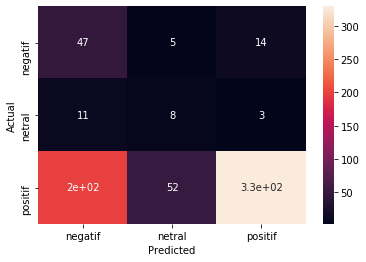

In [21]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
# #                "max_depth": [2, 4, 7, 10],
# #                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
# #                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
# #                "reg_alpha": [0, 0.5, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5],
# #                "min_child_weight": [1, 3, 5, 7],
# #                "n_estimators": [100, 250, 500, 1000]}

# parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10, 12],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.747, total=   6.3s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.785, total=   5.9s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.684, total=   5.9s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.709, total=   5.9s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.709, total=   5.8s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsampl

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.684, total=   5.9s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.835, total=   5.7s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.692, total=   5.6s
[CV] subsample=0.5, reg_lambda=3, reg_alpha=0.001, n_estimators=1000, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8 
[CV]  subs

[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.709, total=   8.7s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.772, total=   9.1s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.696, total=   9.1s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, co

[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.709, total=  12.9s
[CV] subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.759, total=  12.6s
[CV] subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.641, total=  14.0s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0.01, n_estimators=100, min_child_weight=3, max_depth=2, learning_rate=0.01, gamma=0.01, colsampl

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.2min finished


Learning Rate:  0.01
Gamma:  0.5
Max Depth:  12
Subsample:  0.4
Colsample Bytree:  0.3
Alpha:  0.01
Lamda:  2
Min Child Weight:  3
Number of Trees:  1000
